In [18]:
import math
import operator
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import image_data_format
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
relative_path = "./imgs/examples/"
filenames = [
    "1.jpg",
    "2.jpeg",
    "3.jpeg",
    "4.png",
    "5.png",
    "6.jpeg",
    "7.jpg"
]
def get_image(index):
    return f"{relative_path}{filenames[index]}"


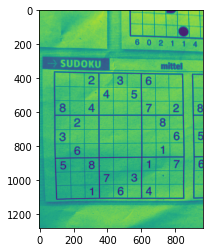

In [3]:
image = cv.imread(get_image(6))
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(gray)

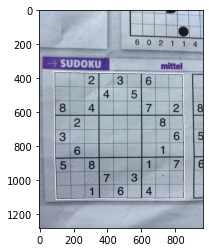

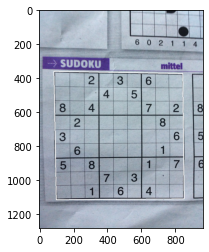

In [4]:

blurred = cv.GaussianBlur(gray.copy(), (7,7), 0)
processed_image = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
countours, _ = cv.findContours(processed_image, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
sudoku_grid = sorted(countours, key=cv.contourArea, reverse=True)[0]

plt.imshow(cv.drawContours(image.copy(), sudoku_grid, -1, (255,255,255), 3))
plt.figure()

epsilon = 0.1 * cv.arcLength(sudoku_grid,True)
grid_edges = cv.approxPolyDP(sudoku_grid, epsilon,True)
continuous_curve = cv.drawContours(image, [grid_edges], -1, (255,255,255), 3)

plt.imshow(continuous_curve)


In [5]:
longest_side = max(
    [
        cv.norm(grid_edges[0][0], grid_edges[1][0]), # top left vs top right
        cv.norm(grid_edges[1][0], grid_edges[2][0]), # top right vs bottom right
        cv.norm(grid_edges[2][0], grid_edges[3][0]), # bottom right vs bottom left
        cv.norm(grid_edges[3][0], grid_edges[0][0])  # bottom left vs top left
    ]
)
print(longest_side)

755.1119122355308


In [6]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
  return result


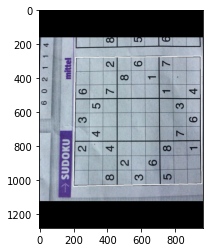

In [7]:
plt.imshow(rotate_image(image, 90))

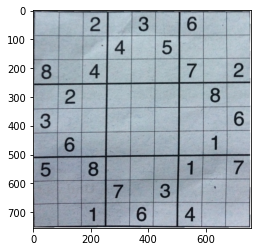

In [8]:
src = np.array([grid_edges[1][0], grid_edges[0][0], grid_edges[3][0], grid_edges[2][0]], dtype=np.float32) 

dst = np.array([[0, 0], [longest_side - 1, 0], [longest_side - 1, longest_side - 1], [0, longest_side - 1]], dtype=np.float32)
tranformed_perspective = cv.getPerspectiveTransform(src, dst)
testing = cv.warpPerspective(image.copy(), tranformed_perspective, (int(longest_side), int(longest_side)))
angle = 90
testing = rotate_image(testing, angle)
plt.imshow(testing)

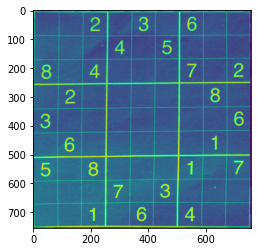

<Figure size 432x288 with 0 Axes>

In [9]:
processed_image = cv.cvtColor(testing.copy(),cv.COLOR_BGR2GRAY)
cv.bitwise_not(processed_image, processed_image)
plt.imshow(processed_image)
plt.figure()
numbers = []
for i in range(9):
    for j in range(9):
        width = int(processed_image.shape[0]/9)
        height = int(processed_image.shape[1]/9)
        numbers.append(processed_image[i*width:i*width + width,j*height:j*height + height])

In [22]:
model = keras.models.load_model("trained_model/")

In [28]:
# constants
CHECKPOINT_PATH = "./trained_model/cp.ckpt"
IMG_ROWS = IMG_COLS = 28
EPOCHS_AMOUNT = 5
CLASSES_AMOUNT = 10
BATCH_SIZE = 200
NUMBER_THREAD = 50

In [31]:
def resize_contour(contour, coef_x, coef_y):
    contour[:, :, 0] = contour[:, :, 0] * coef_x
    contour[:, :, 1] = contour[:, :,  1] * coef_y
    return contour
    

In [ ]:
def preprocess_image(image):
    #_,image = cv.threshold(image,200,255,cv.THRESH_BINARY)
    contours, _ = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    biggest_contour = sorted(contours, key=cv.contourArea, reverse=True)[0]
    M = cv.moments(biggest_contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    image = cv.drawContours(np.zeros((cy*2, cx*2)), contours, -1, (255,255,255))
    image = cv.fillPoly(image,pts=contours,color=(255,255,255))
    return cv.resize(image, (28,28))

C:\Users\david\AppData\Local\Temp\ipykernel_18308\1545515122.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


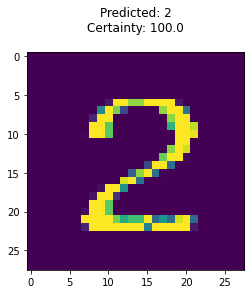

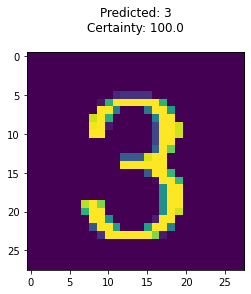

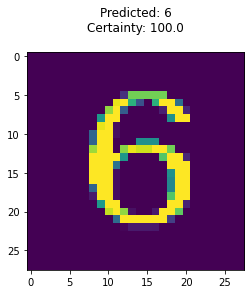

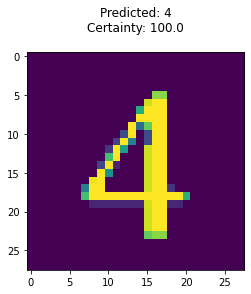

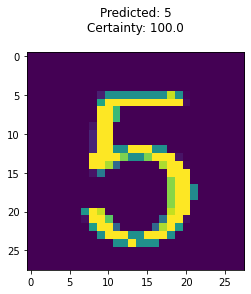

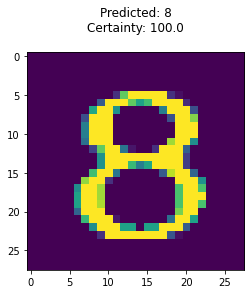

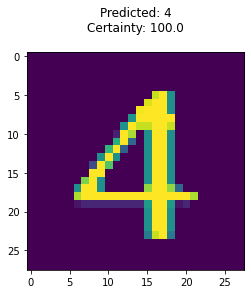

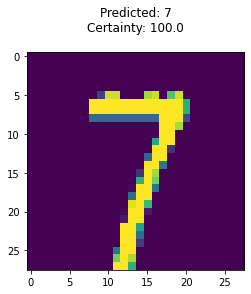

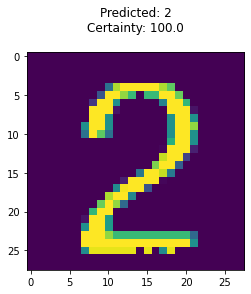

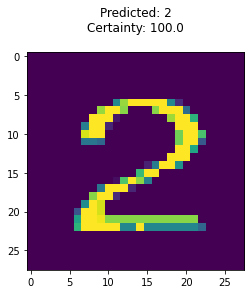

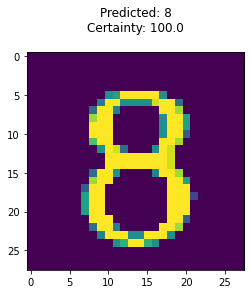

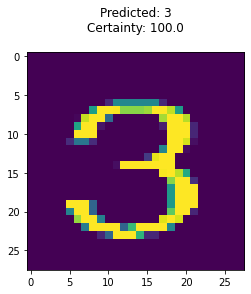

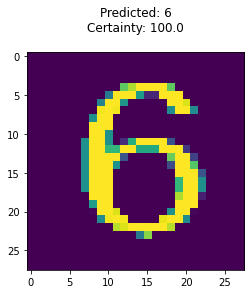

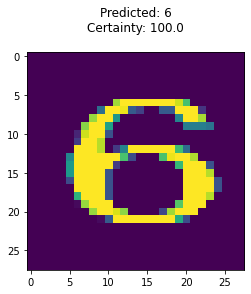

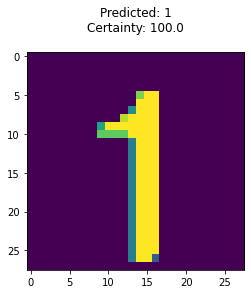

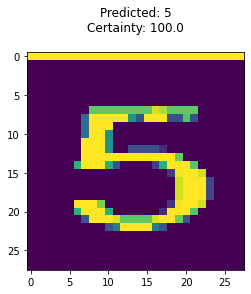

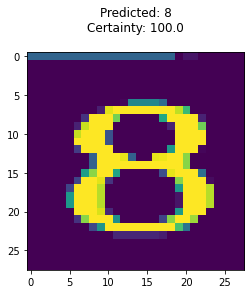

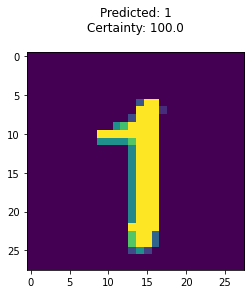

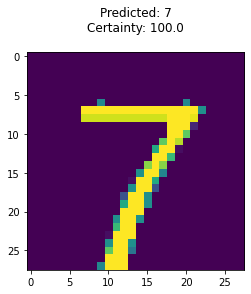

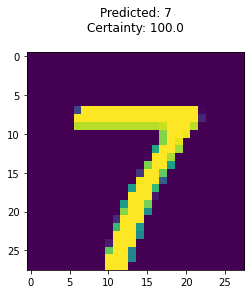

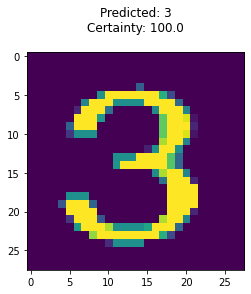

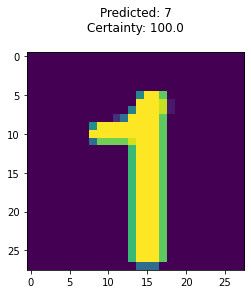

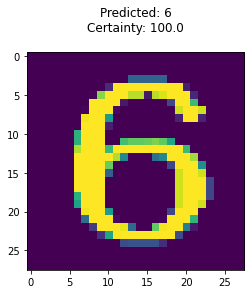

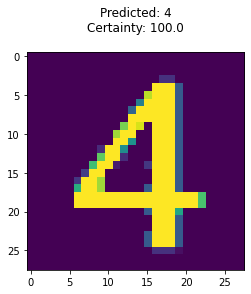

<Figure size 432x288 with 0 Axes>

In [32]:
predicted_number = 0
UP = 0.85
DOWN = 0.15
for num in numbers:
    num = cv.resize(num[int(num.shape[0]*0.15):int(num.shape[0]),int(num.shape[1]*0.2):int(num.shape[1])], (60,60))
    _,num = cv.threshold(num,150,255,cv.THRESH_BINARY)
    
    if cv.countNonZero(num) > 75:

        contours, _ = cv.findContours(num, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        M = cv.moments(sorted(contours, key=cv.contourArea, reverse=True)[0])
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        
        num = cv.drawContours(np.zeros((cy*2, cx*2)), contours, -1, (255,255,255))
        num = cv.fillPoly(num,pts=contours, color=(255,255,255))
        num = cv.resize(num, (28,28))
        num = cv.erode(num, (3,3))

        prediction = sorted(enumerate(new_model.predict(num.reshape(1, IMG_ROWS, IMG_COLS, 1))[0]), key=operator.itemgetter(1), reverse=True)[0]
        plt.title(f"Predicted: {prediction[0]}\nCertainty: {prediction[1]*100}\n")
        plt.imshow(num)
        plt.figure()

    

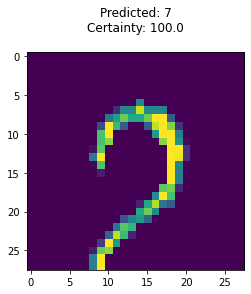

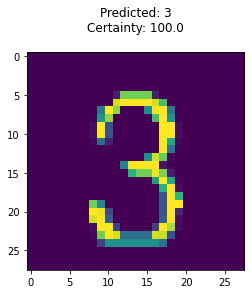

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_number = 0
UP = 0.85
DOWN = 0.15
for num in numbers[:5]:
    num = cv.resize(num[int(num.shape[0]*DOWN):int(num.shape[0]*UP),int(num.shape[1]*DOWN):int(num.shape[1]*UP)], (28,28))
    #cv.bitwise_not(num, num)
    _,num = cv.threshold(num,200,255,cv.THRESH_BINARY)
    
    if cv.countNonZero(num) > 50:
        num = preprocess_image(num)
        prediction = sorted(enumerate(new_model.predict(num.reshape(1, IMG_ROWS, IMG_COLS, 1))[0]), key=operator.itemgetter(1), reverse=True)[0]
        #predicted_number = new_model.predict(num.reshape(1, IMG_ROWS, IMG_COLS, 1)).argmax()
        plt.title(f"Predicted: {prediction[0]}\nCertainty: {prediction[1]*100}\n")
        #print(f"Center of number: {cx}, {cy}\nCenter of an image: {num.shape[0]/2}, {num.shape[1]/2}")

        plt.imshow(num)
        plt.figure()
    